# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import sys
import time

import arviz as az
import jax
from jax import numpy as jnp
from jax.random import PRNGKey
import numpy as np
import pandas as pd
from optax import adam
import tensorflow_probability.substrates.jax.distributions as tfd


sys.path.append(os.path.abspath(".."))
from scripts.notebook_utils import (
    plot_elbo, 
    plot_true_predicted_comparison, 
    plot_regression_results, 
    plot_synthetic_data,
    plot_data,
    REGRESSION_COLORPALETTE,
    TRUEPARAM_COLORPALETTE,
    PREDPARAM_COLORPALETTE,
    ELBO_COLOR,
)
from scripts.vigamlss import (
    Normal, 
    Gamma, 
    GEV,
    DataPreparator, 
    DegenerateNormal, 
    FullCovarianceNormal, 
    MeanFieldNormal, 
    HalfCauchy, 
    TransformationFunctions,
)

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

2025-02-07 17:23:24.601870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738945404.664885  155686 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738945404.681831  155686 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# VIGAMLSS with Gamma Response

## Plan

In [2]:
def vigamlss_gamma_prepare_data():
    dbbmi_df = pd.read_csv("../data/dbbmi_data.csv")
    Y: np.ndarray = dbbmi_df["bmi"].values
    Y: jnp.ndarray = jnp.array(Y)
    X: np.ndarray = dbbmi_df["age"].values
    X: jnp.ndarray = jnp.array(X)
    DesignMatrix, K = DataPreparator(
        "dbbmi DesignMatrix",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=20,
    )()
    return DesignMatrix, X, Y, K


def vigamlss_gamma_define_model(DesignMatrix, Y, K):
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)
    β0_loc = Normal("beta_0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)
    β0_scale = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    Y = Gamma(
        "y",
        β0_loc + DesignMatrix @ γ_loc,
        β0_scale + DesignMatrix @ γ_scale,
        responses=Y,
    )
    return Y


def vigamlss_gamma_run_opt(Y):
    start_time = time.time()
    results = Y.model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=2000,
        mb_size=512,
        lr=0.01,
        max_norm=1.0,
        clip_min_max_enabled=False,
        zero_nans_enabled=False,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    print(f"Elapsed time for opt: {int(minutes)} min: {seconds:.2f} sec")
    return results

def vigamlss_gamma_results(results, X, Y):
    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta_0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta_0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]

    X_min, X_max = X.min(), X.max()
    X_SYN = np.linspace(X_min, X_max, 1000)
    SYN_DesignMatrix = DataPreparator(
        "xDesign", X_SYN, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
    )()

    linear_predictor_concentration = TransformationFunctions.softplus(β0_loc_opt + SYN_DesignMatrix.matrix @ γ_loc_opt)
    linear_predictor_rate = TransformationFunctions.softplus(β0_scale_opt + SYN_DesignMatrix.matrix @ γ_scale_opt)

    GAMMAs = tfd.Gamma(linear_predictor_concentration, linear_predictor_rate)
    samples = GAMMAs.sample((100000,),PRNGKey(0))
    samples = np.array(samples)
    pred_mean_line = GAMMAs.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:,0]
    pred_hdi_upper = pred_hdi_bounds[:,1]

    plot_data(
        X=X, 
        Y=Y, 
        scatterplot_color=REGRESSION_COLORPALETTE[0], 
        scatter_xlabel="AGE", 
        scatter_ylabel="BMI", 
        scatter_title="DBBMI",
    )
    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.8,
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X_SYN,
        pred_mean=pred_mean_line,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label='Data Points',
        regression_label='Regression Line',
        hdi_label='95% HDI',
        xlabel='AGE',
        ylabel='BMI',
        title='Dutch Boys AGE vs BMI with P-Spline Prediction Mean and 95% HDI',
    )

## Conduct

Elapsed time for opt: 0 min: 18.88 sec


/tmp/ipykernel_310858/3087327853.py:76: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


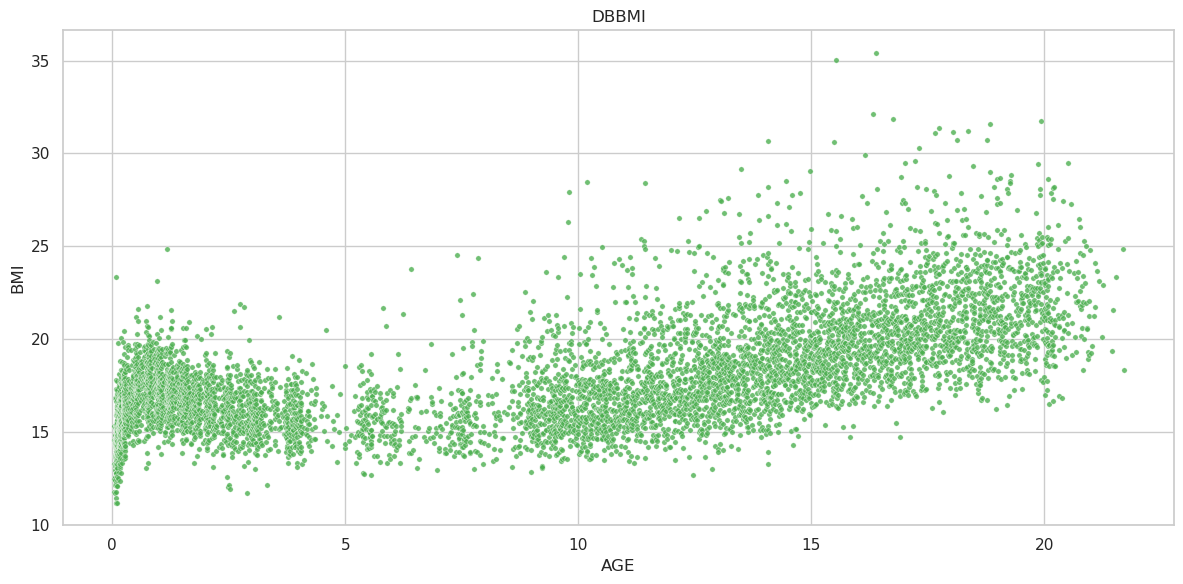

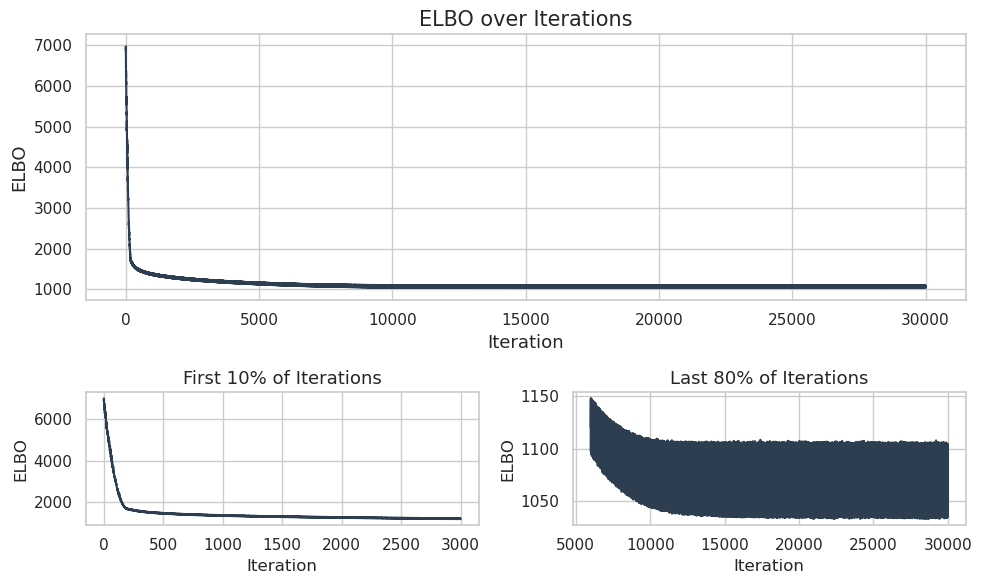

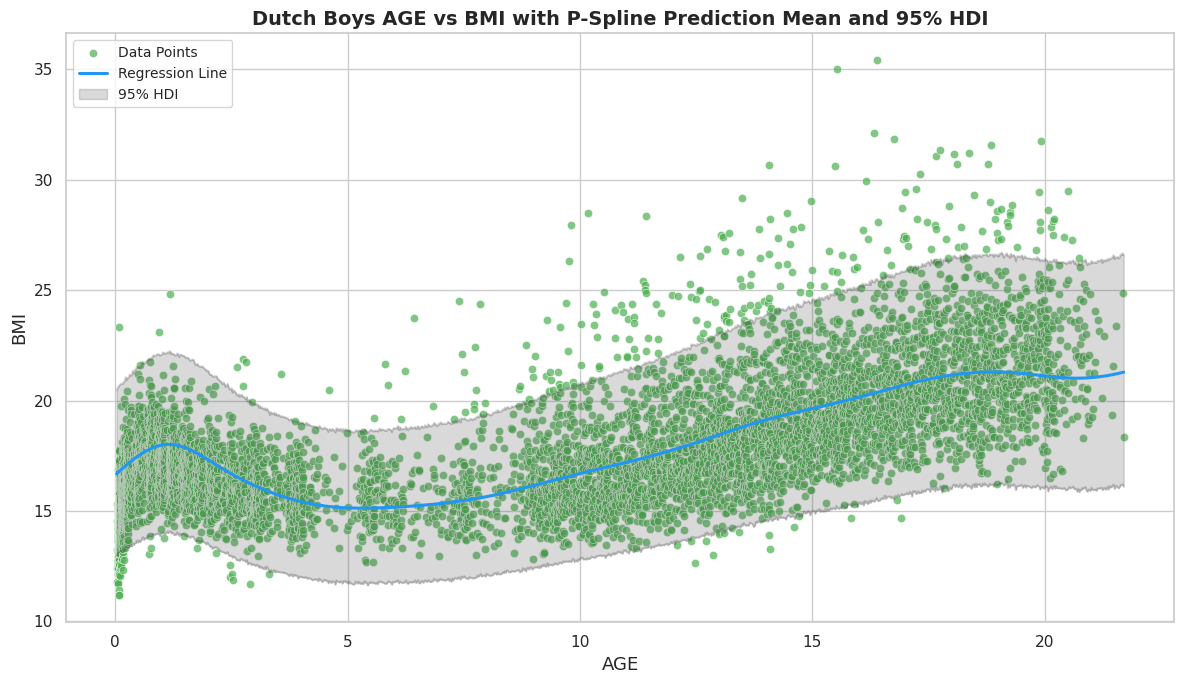

In [9]:
DesignMatrix, X, Y, K = vigamlss_gamma_prepare_data()
model = vigamlss_gamma_define_model(DesignMatrix, Y, K)
results = vigamlss_gamma_run_opt(model)
vigamlss_gamma_results(results, X, Y)

# VIGAMLSS with GEV Response

## Synthetic Data Creation

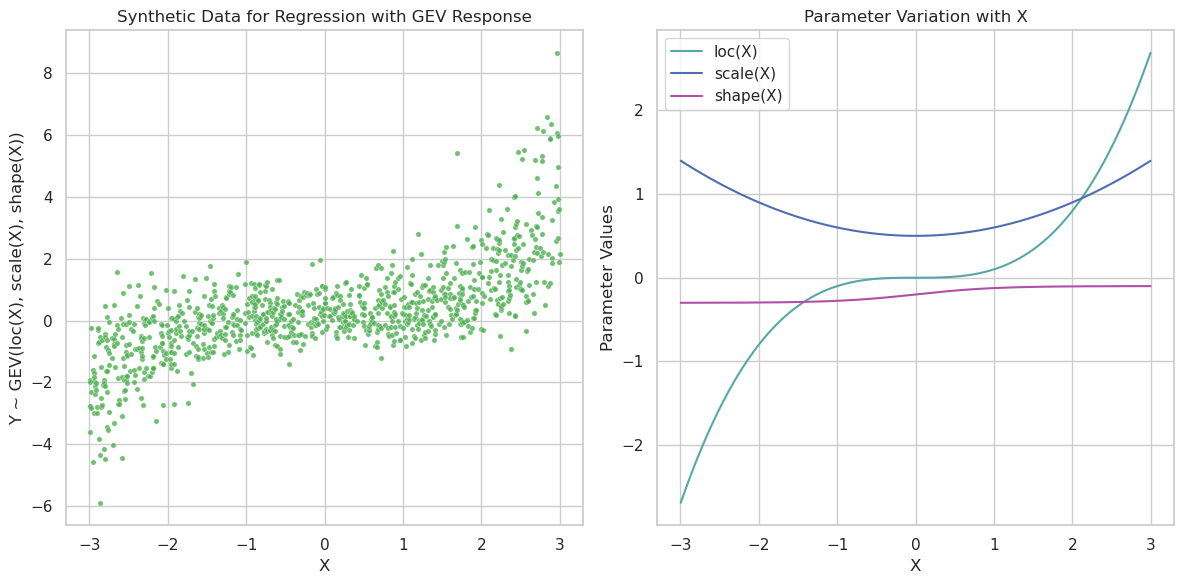

In [12]:
def vigamlss_gev_create_syn_data():
    # ------------------------------------------------
    # 1) Generate covariate X
    # ------------------------------------------------
    key = PRNGKey(42)
    n_samples = 1000
    key_x, key_y = jax.random.split(key)
    X_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
    X_SYN   = jnp.sort(X_SYN)
    # ------------------------------------------------
    # 2) Define parametric functions for loc(x), scale(x), shape(x)
    # ------------------------------------------------
    def loc_fn(x):
        return 0.1 * x**3
    def scale_fn(x):
        return 0.1 * x**2 + 0.5
    def shape_fn(x):
        return 0.1 * jnp.tanh(x) - 0.2
    loc_vals   = loc_fn(X_SYN)
    scale_vals = scale_fn(X_SYN)
    shape_vals = shape_fn(X_SYN)
    # ------------------------------------------------
    # 3) Constructs a *batch* of GEVs, one per (x_i).
    #    TFP automatically enforces domain logic for each sample.
    # ------------------------------------------------
    gev_dists = tfd.GeneralizedExtremeValue(
        loc          = loc_vals,     # shape=(n_samples,)
        scale        = scale_vals,   # shape=(n_samples,)
        concentration= shape_vals    # shape=(n_samples,)
    )
    # ------------------------------------------------
    # 4) Sample Y given X
    # ------------------------------------------------
    Y_SYN = gev_dists.sample(seed=key_y)  # shape=(n_samples,)
    Y_SYN = jnp.array(Y_SYN)

    plot_synthetic_data(
        X=X_SYN,
        Y=Y_SYN,
        scatterplot_color=REGRESSION_COLORPALETTE[0],
        line_palette=TRUEPARAM_COLORPALETTE,
        lines=[loc_vals, scale_vals, shape_vals],
        scatter_xlabel="X",
        scatter_ylabel="Y ~ GEV(loc(X), scale(X), shape(X))",
        scatter_title="Synthetic Data for Regression with GEV Response",
        line_xlabel="X",
        line_ylabel="Parameter Values",
        line_title="Parameter Variation with X",
        line_labels=["loc(X)","scale(X)","shape(X)"],
    )

    return X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals

GEV_X_SYN, GEV_Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gev_create_syn_data()

## Simple Linear Predictors

### Plan

In [13]:
def vigamlss_gev_slp_prepare_data(X):
    DesignMatrix = DataPreparator(
        "DesignMatrix",
        X,
        "identity",
        intercept=True,
        standardize=True,
    )()

    return DesignMatrix


def vigamlss_gev_slp_define_model(DesignMatrix, Y):
    ncols = DesignMatrix.matrix.shape[1]
    β_loc = Normal("betas_loc", jnp.zeros(ncols), jnp.ones(ncols) * 10.0, ncols)
    β_scale = Normal("betas_scale", jnp.zeros(ncols), jnp.ones(ncols) * 10.0, ncols)
    β_shape = Normal("betas_shape", jnp.zeros(ncols), jnp.ones(ncols) * 10.0, ncols)
    Y = GEV(
        "y",
        DesignMatrix @ β_loc,
        DesignMatrix @ β_scale,
        DesignMatrix @ β_shape,
        responses=Y,
    )
    return Y


def vigamlss_gev_slp_run_opt(Y):
    start_time = time.time()
    results = Y.model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=10000,
        mb_size=None,
        lr=0.0001,
        max_norm=1.0,
        clip_min_max_enabled=False,
        zero_nans_enabled=False,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    return results


def vigamlss_gev_slp_results(results, DesignMatrix, X, Y, loc_vals, scale_vals, shape_vals):
    β_loc_opt = results["transformed_loc_vi_parameters"]["betas_loc"]
    β_scale_opt = results["transformed_loc_vi_parameters"]["betas_scale"]
    β_shape_opt = results["transformed_loc_vi_parameters"]["betas_shape"]

    linear_predictor_loc = DesignMatrix.matrix @ β_loc_opt
    linear_predictor_scale = DesignMatrix.matrix @ β_scale_opt
    linear_predictor_shape = DesignMatrix.matrix @ β_shape_opt

    gev_dists = tfd.GeneralizedExtremeValue(
        linear_predictor_loc, linear_predictor_scale, linear_predictor_shape
    )
    samples = gev_dists.sample((100000,), PRNGKey(0))
    samples = np.array(samples)

    pred_mean_line = gev_dists.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.8,
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X,
        pred_mean=pred_mean_line,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label="Data Points",
        regression_label="Regression Line",
        hdi_label="95% HDI",
        xlabel="X",
        ylabel="Response",
        title="GEV Synthetic Data Regression with 95% HDI",
    )
    plot_true_predicted_comparison(
        X=X,
        true_parameter_values=[loc_vals, scale_vals, shape_vals],
        predicted_parameter_values=[linear_predictor_loc, linear_predictor_scale, linear_predictor_shape],
        true_palette=PREDPARAM_COLORPALETTE,
        pred_palette=PREDPARAM_COLORPALETTE,
        line_labels=["Location", "Scale", "Shape"],
        title="Comparison of Synthetic GEV Location, Scale and Shape to Predicted Ones",
        xlabel="X",
        ylabel="Y",
    )

### Conduct

Elapsed time for optimization: 0 min: 2.63 sec


/tmp/ipykernel_378811/4271656989.py:66: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


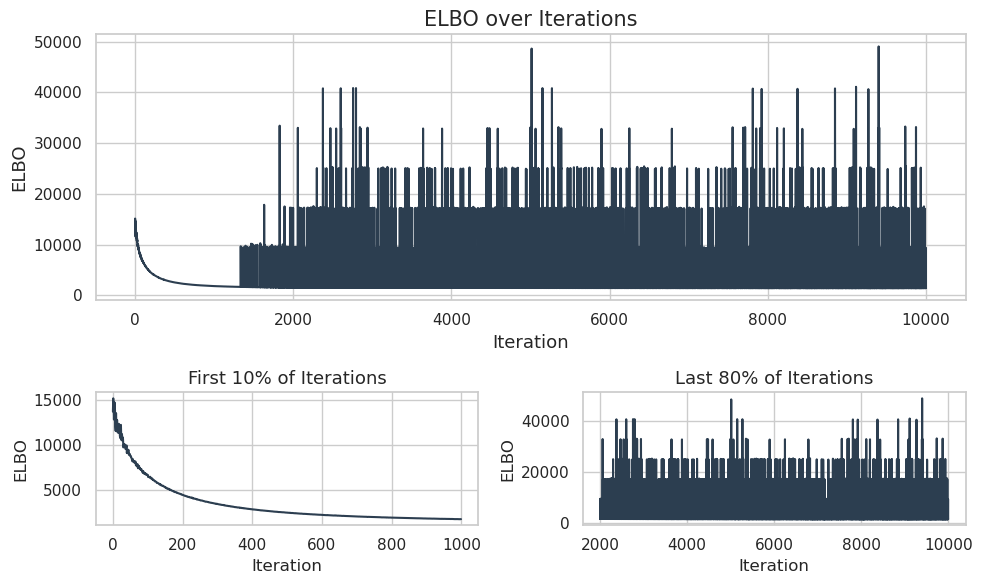

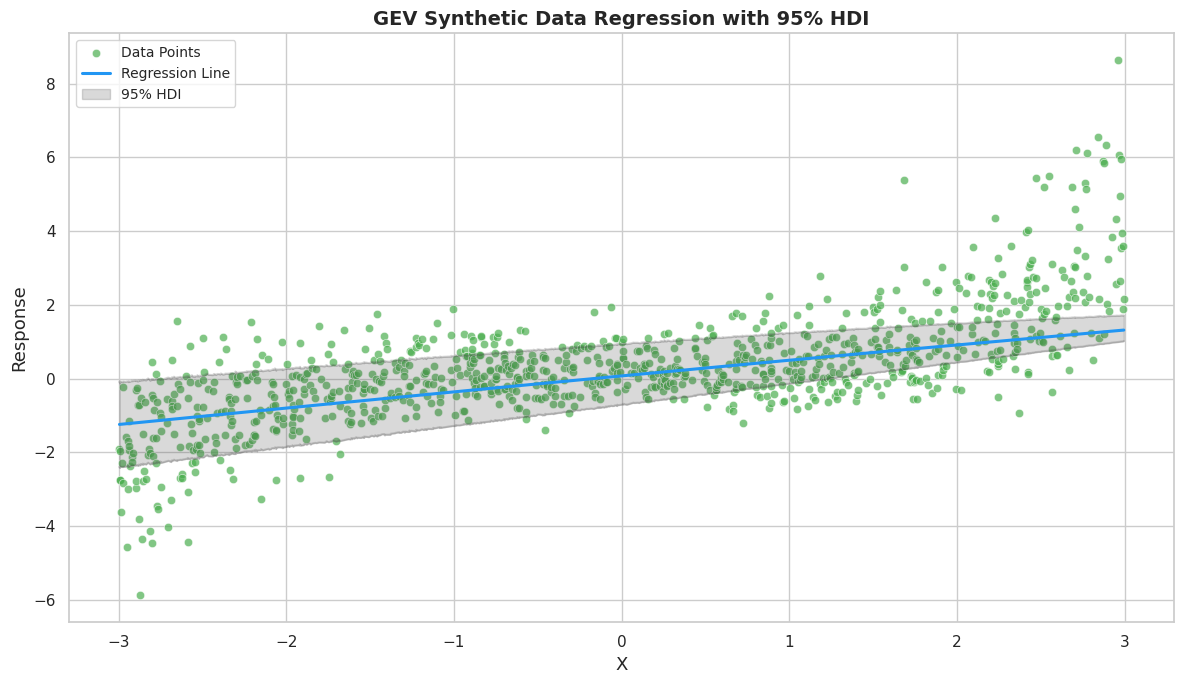

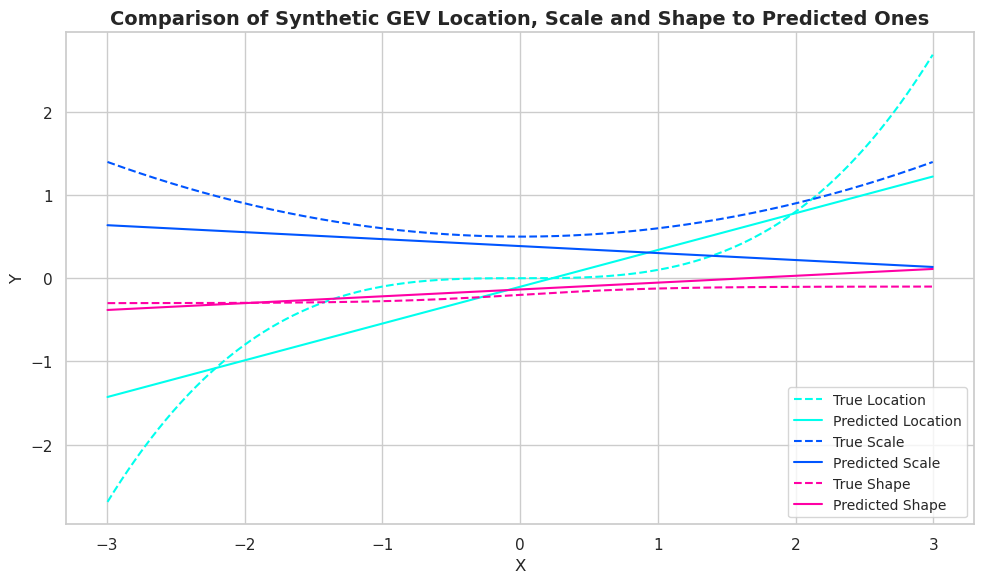

In [14]:
DesignMatrix = vigamlss_gev_slp_prepare_data(GEV_X_SYN)
model = vigamlss_gev_slp_define_model(DesignMatrix, GEV_Y_SYN)
results = vigamlss_gev_slp_run_opt(model)
vigamlss_gev_slp_results(results, DesignMatrix, GEV_X_SYN, GEV_Y_SYN, loc_vals, scale_vals, shape_vals)

## PSplines

### Preperations

#### 10 Knots DataPreperation

In [33]:
def vigamlss_gev_pspline10knots_prepare_data(X):
    DesignMatrix, K = DataPreparator(
        "xDesign",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
    )()
    return DesignMatrix, K

#### 20 Knots DataPreperation

In [34]:
def vigamlss_gev_pspline20knots_prepare_data(X):
    DesignMatrix, K = DataPreparator(
        "xDesign",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=20,
    )()
    return DesignMatrix, K

##### Model Definition and Results Aggregation

In [35]:
def vigamlss_gev_pspline_define_model(DesignMatrix, Y, K):    
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)
    
    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)
    
    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.1]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = GEV(
        "y",
        β0_loc + DesignMatrix @ γ_loc,
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y,
    )
    return Y

def vigamlss_gev_pspline_results(results, DesignMatrix, X, Y, loc_vals, scale_vals, shape_vals):
    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results["transformed_loc_vi_parameters"]["gammas_shape"]

    linear_predictor_loc = β0_loc_opt + DesignMatrix.matrix @ γ_loc_opt
    linear_predictor_scale = TransformationFunctions.softplus(β0_scale_opt + DesignMatrix.matrix @ γ_scale_opt)
    linear_predictor_shape = β0_shape_opt + DesignMatrix.matrix @ γ_shape_opt

    gev_dists = tfd.GeneralizedExtremeValue(
        linear_predictor_loc, 
        linear_predictor_scale, 
        linear_predictor_shape
    )
    samples = gev_dists.sample((100000,), PRNGKey(0))
    samples = np.array(samples)

    pred_mean_line = gev_dists.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.8,
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X,
        pred_mean=pred_mean_line,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label="Data Points",
        regression_label="Regression Line",
        hdi_label="95% HDI",
        xlabel="X",
        ylabel="Response",
        title="GEV P-Spline Regression with 95% HDI",
    )
    plot_true_predicted_comparison(
        X=X,
        true_parameter_values=[loc_vals, scale_vals, shape_vals],
        predicted_parameter_values=[
            linear_predictor_loc, 
            linear_predictor_scale, 
            linear_predictor_shape
        ],
        true_palette=TRUEPARAM_COLORPALETTE,
        pred_palette=PREDPARAM_COLORPALETTE,
        line_labels=["Location", "Scale", "Shape"],
        title="Comparison of True vs Predicted GEV Parameters",
        xlabel="X",
        ylabel="Parameter Value",
    )

##### MeanField VI Dist Opt. Run

In [46]:
def vigamlss_gev_pspline_MF_run_opt(Y):
    start_time = time.time()
    results = Y.model.run_svi_optimization(
        optimizer=adam,
        vi_dist=MeanFieldNormal,
        vi_sample_size=64,
        epochs=50000,
        mb_size=None,
        lr=0.0001,
        max_norm=1.0,
        clip_min_max_enabled=False,
        zero_nans_enabled=True,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    return results

##### FullCovariance VI Dist Opt. Run

In [54]:
def vigamlss_gev_pspline_FC_run_opt(Y):
    start_time = time.time()
    results = Y.model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=10000,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    return results

### Conduct

#### 10 Knots

##### Conduct MF VI Dist. Opt. Run

Elapsed time for optimization: 0 min: 25.12 sec


/tmp/ipykernel_378811/2805826510.py:44: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


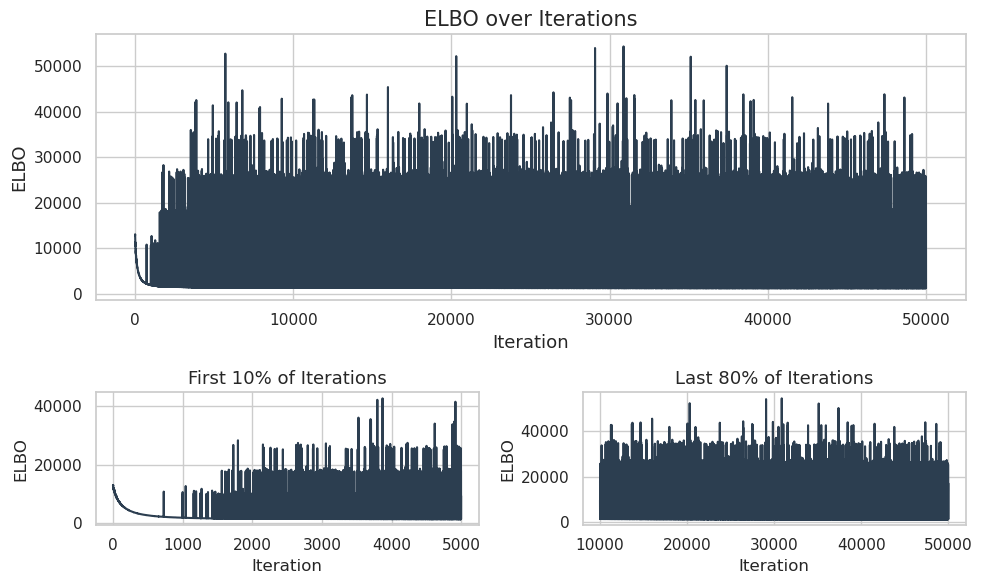

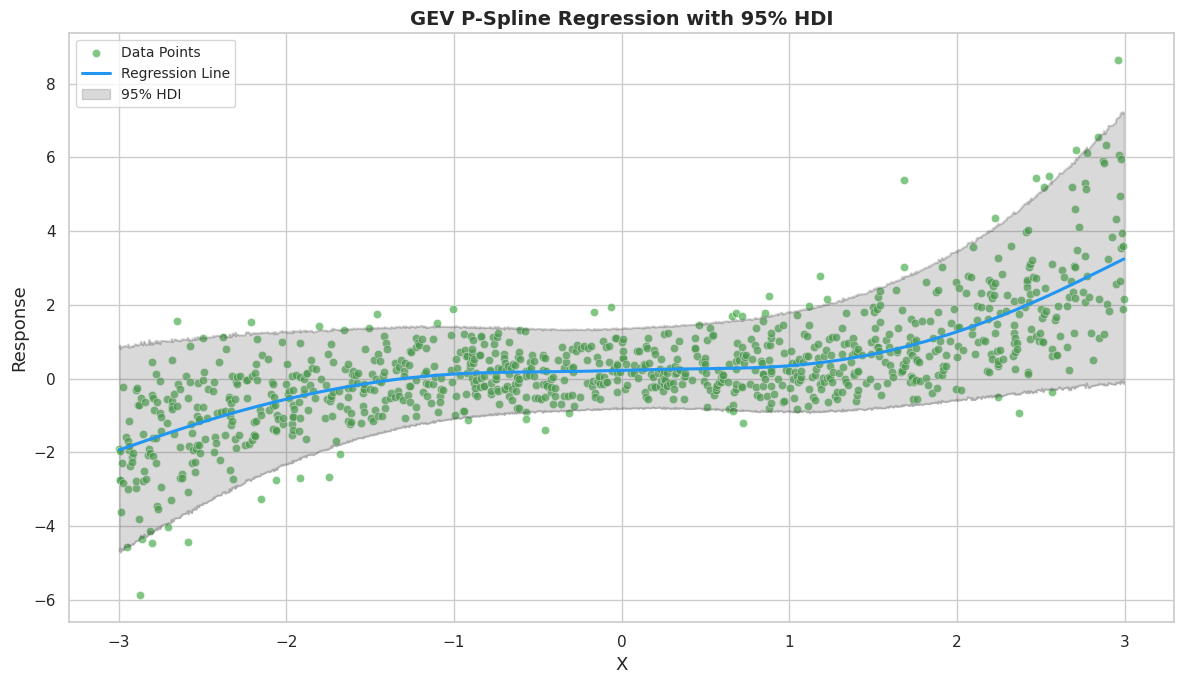

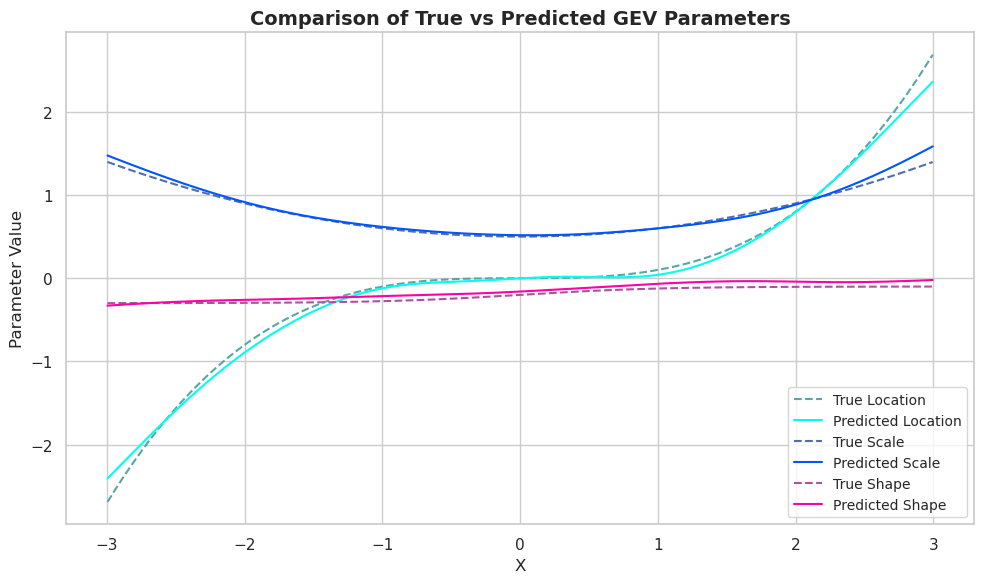

In [47]:
DesignMatrix, K = vigamlss_gev_pspline10knots_prepare_data(GEV_X_SYN)
model = vigamlss_gev_pspline_define_model(DesignMatrix, GEV_Y_SYN, K)
results = vigamlss_gev_pspline_MF_run_opt(model)
vigamlss_gev_pspline_results(results, DesignMatrix, GEV_X_SYN, GEV_Y_SYN, loc_vals, scale_vals, shape_vals)

##### Conduct FC Dist. Opt. run

Elapsed time for optimization: 0 min: 8.45 sec


/tmp/ipykernel_378811/2805826510.py:44: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


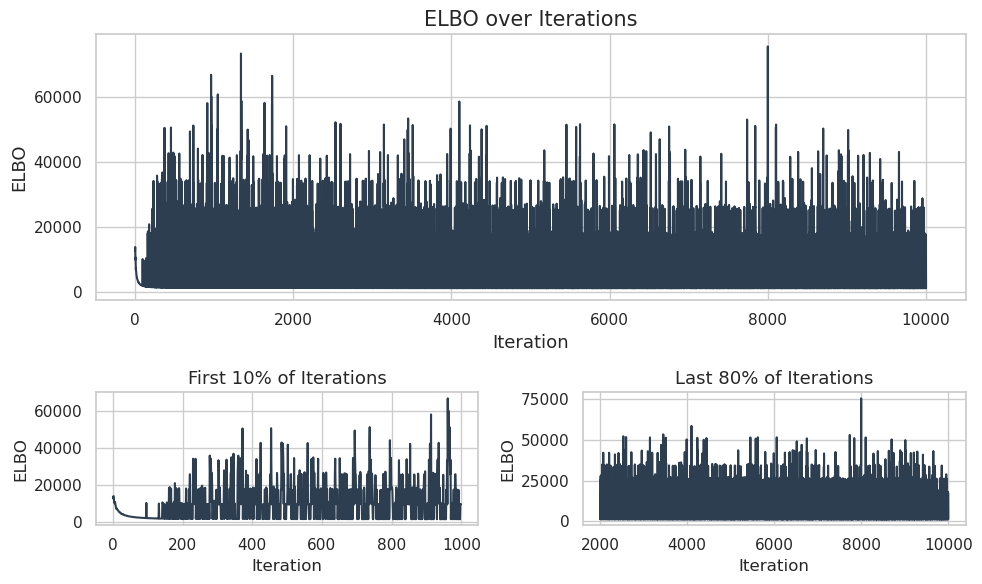

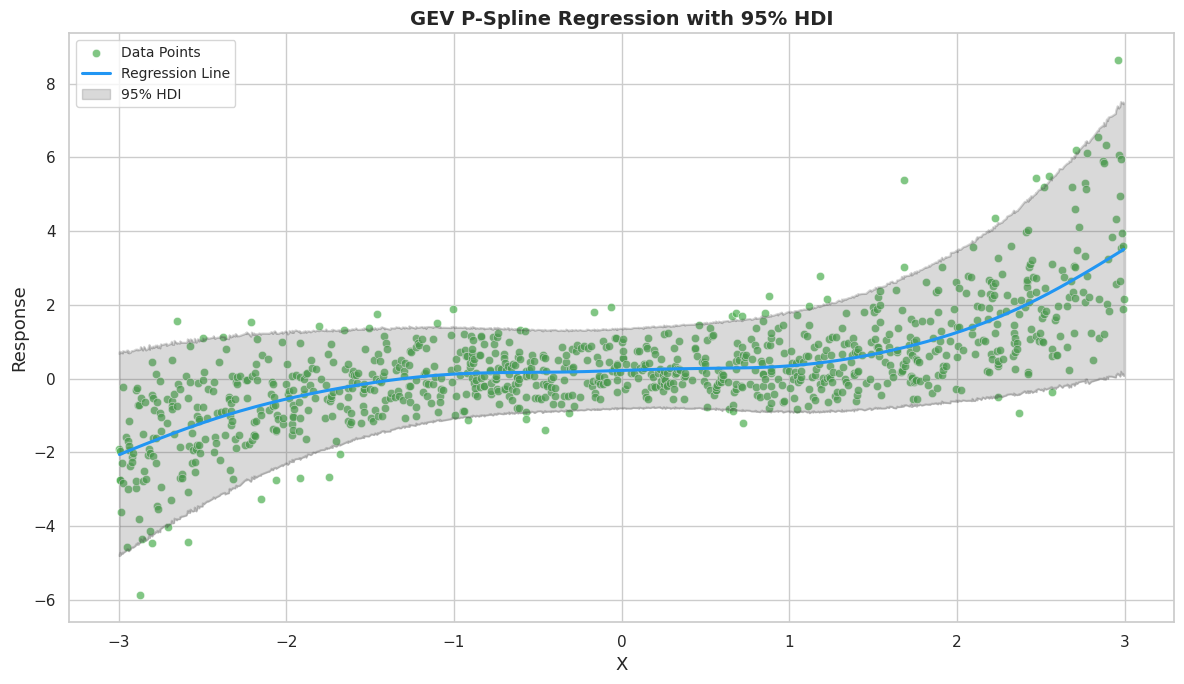

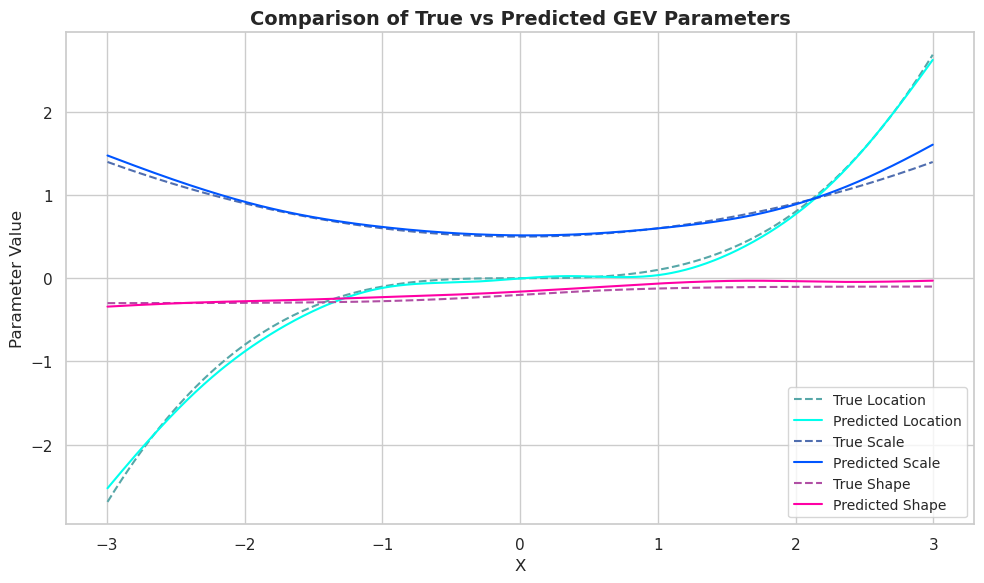

In [55]:
DesignMatrix, K = vigamlss_gev_pspline10knots_prepare_data(GEV_X_SYN)
model = vigamlss_gev_pspline_define_model(DesignMatrix, GEV_Y_SYN, K)
results = vigamlss_gev_pspline_FC_run_opt(model)
vigamlss_gev_pspline_results(results, DesignMatrix, GEV_X_SYN, GEV_Y_SYN, loc_vals, scale_vals, shape_vals)

#### 20 Knots

##### Conduct MF VI Dist. Opt. Run

Elapsed time for optimization: 0 min: 28.52 sec


/tmp/ipykernel_378811/2805826510.py:44: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


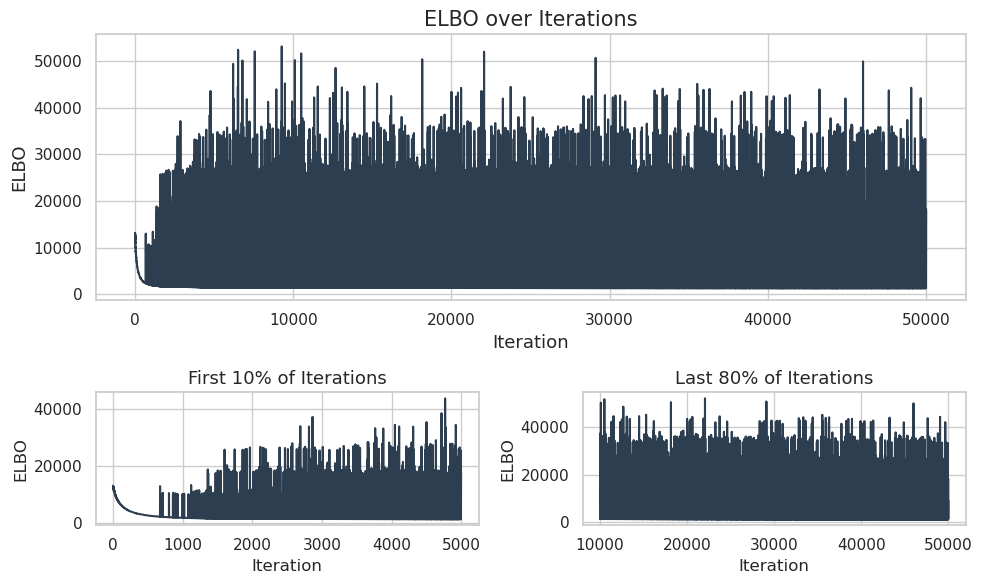

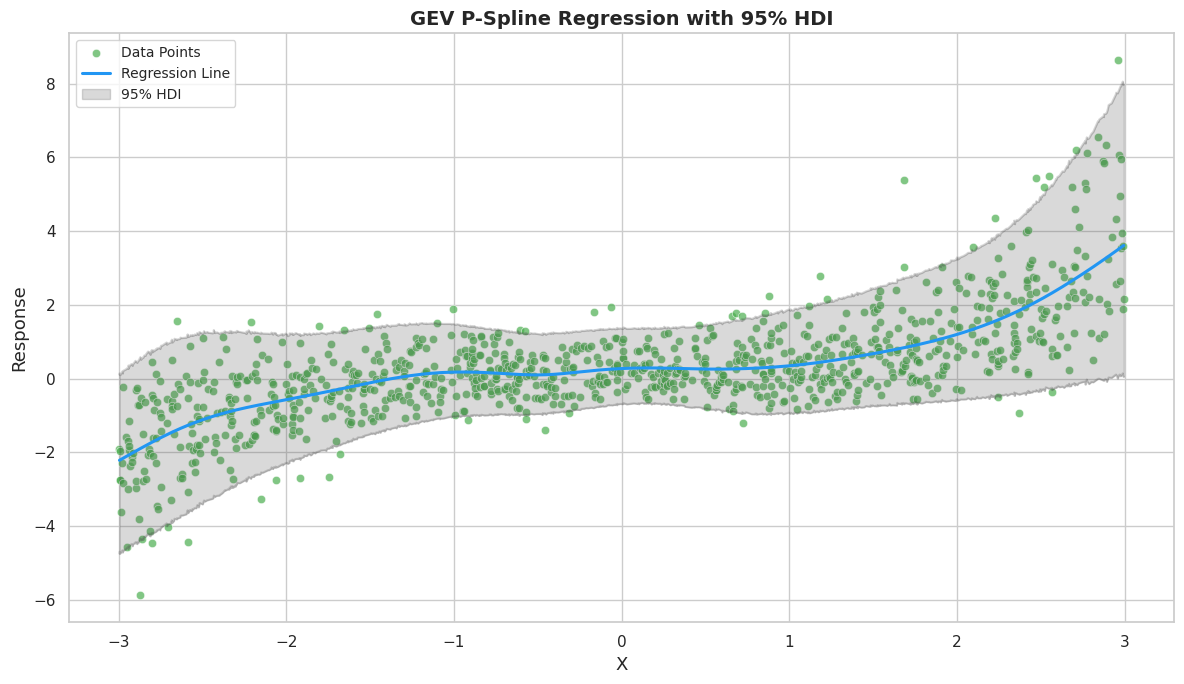

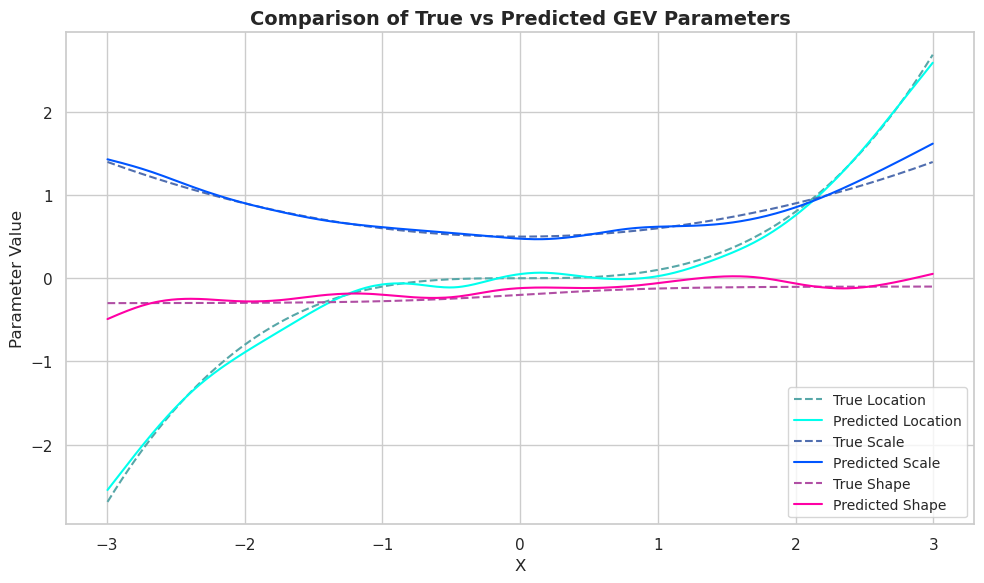

In [56]:
DesignMatrix, K = vigamlss_gev_pspline20knots_prepare_data(GEV_X_SYN)
model = vigamlss_gev_pspline_define_model(DesignMatrix, GEV_Y_SYN, K)
results = vigamlss_gev_pspline_MF_run_opt(model)
vigamlss_gev_pspline_results(results, DesignMatrix, GEV_X_SYN, GEV_Y_SYN, loc_vals, scale_vals, shape_vals)

##### Conduct FC Dist. Opt. run

Elapsed time for optimization: 0 min: 9.79 sec


/tmp/ipykernel_378811/2805826510.py:44: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


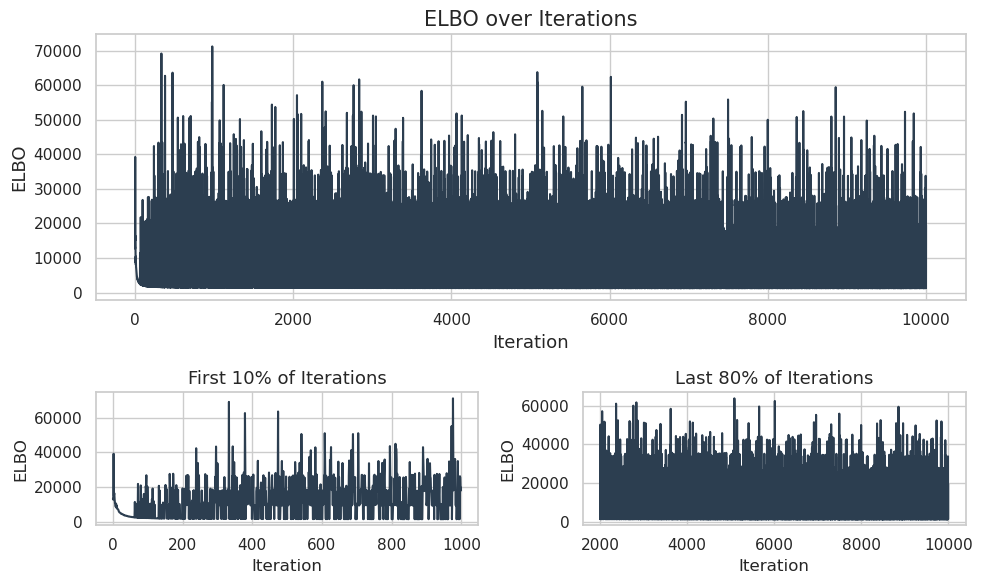

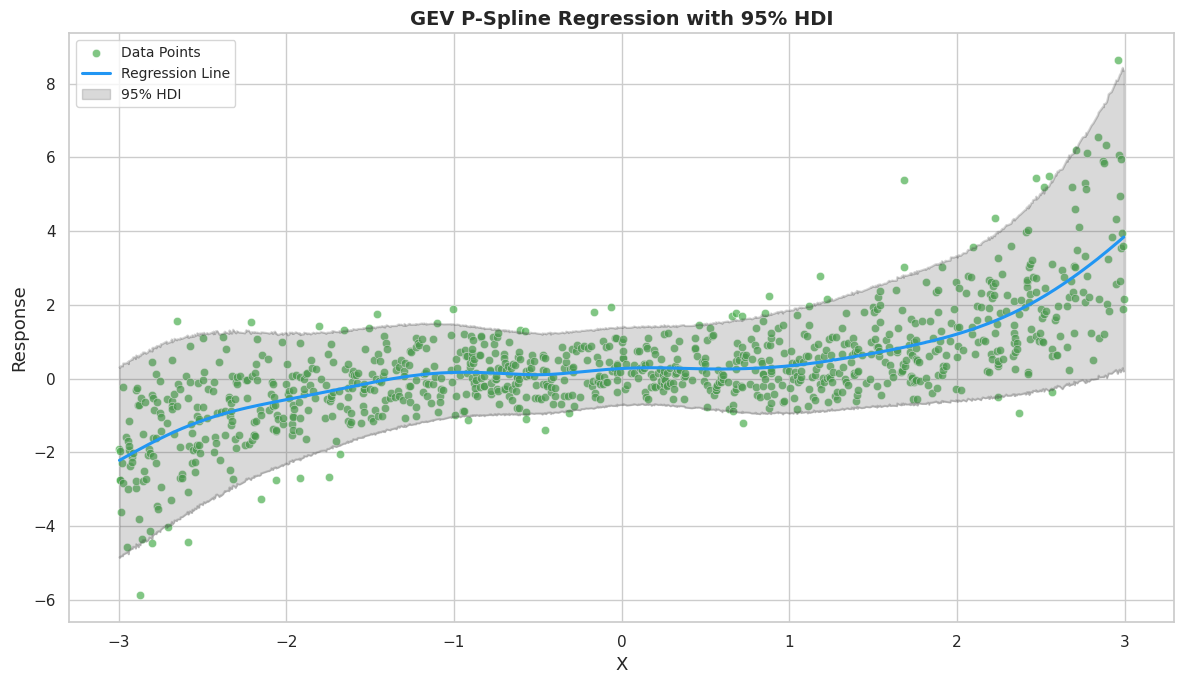

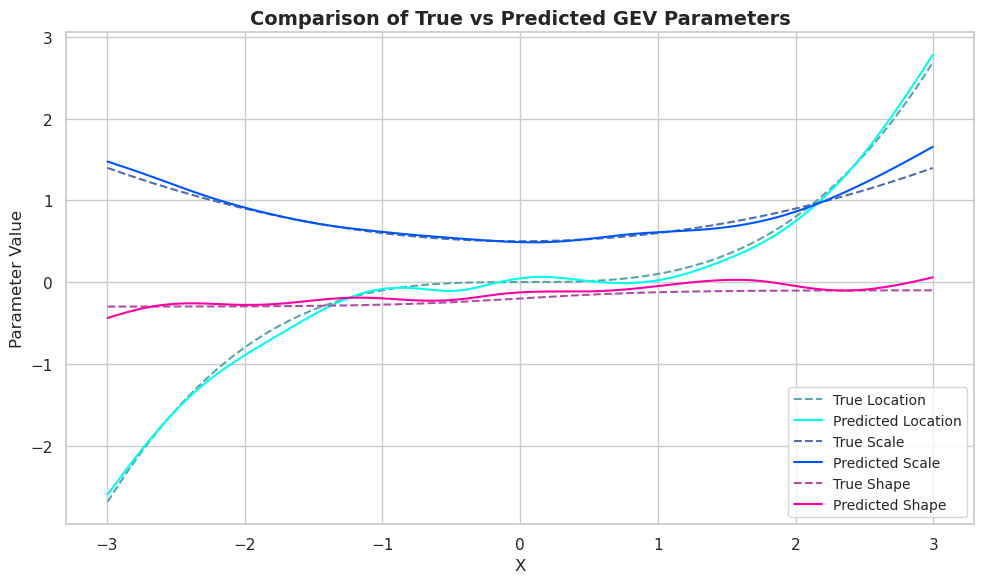

In [57]:
DesignMatrix, K = vigamlss_gev_pspline20knots_prepare_data(GEV_X_SYN)
model = vigamlss_gev_pspline_define_model(DesignMatrix, GEV_Y_SYN, K)
results = vigamlss_gev_pspline_FC_run_opt(model)
vigamlss_gev_pspline_results(results, DesignMatrix, GEV_X_SYN, GEV_Y_SYN, loc_vals, scale_vals, shape_vals)

## VIGAMLSS with GPD Response and PSplines

### Synthetic Data Creation

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gpd_fits/gpd_syn_data_plot.svg


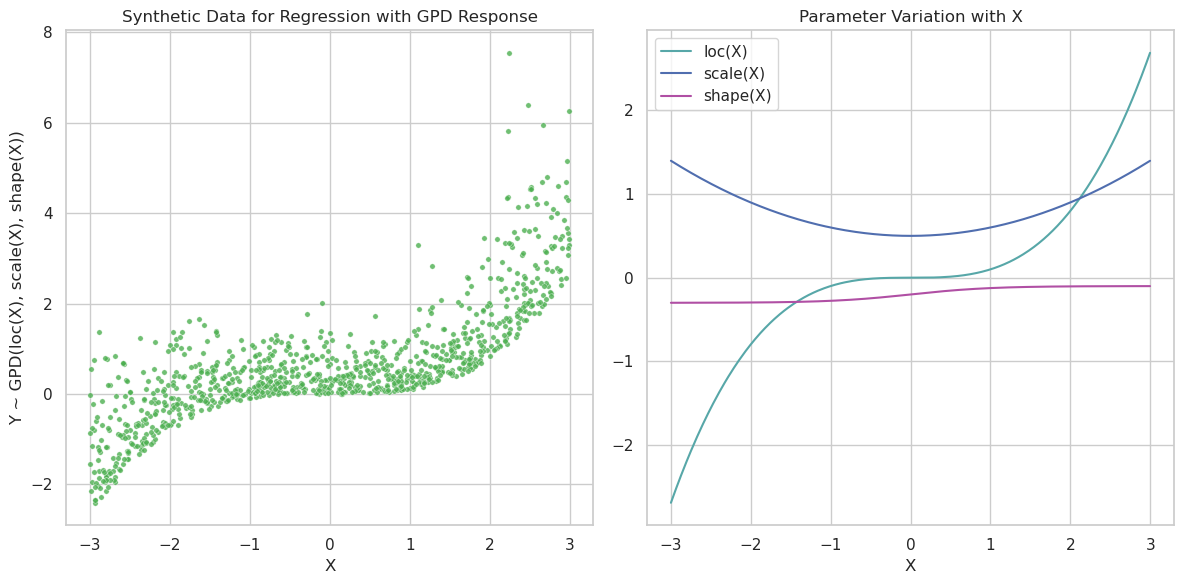

In [5]:
# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GPD_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
xs_sorted   = jnp.sort(X_GPD_SYN)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    return 0.1 * x**3

def scale_fn(x):
    return 0.1 * x**2 + 0.5

def shape_fn(x):
    return 0.1 * jnp.tanh(x) - 0.2

loc_vals   = loc_fn(X_GPD_SYN)
scale_vals = scale_fn(X_GPD_SYN)
shape_vals = shape_fn(X_GPD_SYN)

# ------------------------------------------------
# 3) Constructs a *batch* of GPDs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gpd_dists = tfd.GeneralizedPareto(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GPD_SYN_tf = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GPD_SYN_data = jnp.array(Y_GPD_SYN_tf)


plot_gev_gpd_syn_data(
    X_GPD_SYN, 
    Y_GPD_SYN_data,
    regression_palette, 
    line_colors, 
    loc_fn,
    scale_fn,
    shape_fn,
    "X",
    "Y ~ GPD(loc(X), scale(X), shape(X))",
    "Synthetic Data for Regression with GPD Response",
    "X",
    "Parameter Variation with X",
    "loc(X)",
    "scale(X)",
    "shape(X)",
    "gpd_syn_data_plot",
    gpd_fits_dir,
)


### 10 Knots

#### Model

In [17]:
X_GPD_SYM_PSpline_DesignMatrix = DataPreperator(
    "xDesign",
    X_GPD_SYN,
    "pspline",
    intercept=False,
    standardize=True,
    degree=3,
    num_knots=10,
)()
K = X_GPD_SYM_PSpline_DesignMatrix.K

β0_loc_GPD_PSpline = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_loc_GPD_PSpline = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
γ_loc_GPD_PSpline = DegenerateNormal("gammas_loc", K, λ_loc_GPD_PSpline)
β0_scale_GPD_PSpline = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_scale_GPD_PSpline = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
γ_scale_GPD_PSpline = DegenerateNormal("gammas_scale", K, λ_scale_GPD_PSpline)
β0_shape_GPD_PSpline = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_shape_GPD_PSpline = HalfCauchy("lambda_shape", jnp.array([0.01]), 1)
γ_shape_GPD_PSpline = DegenerateNormal("gammas_shape", K, λ_shape_GPD_PSpline)

Y_GPD_SYN_PSpline = CustomGPD(
    "y",
    β0_loc_GPD_PSpline + X_GPD_SYM_PSpline_DesignMatrix @ γ_loc_GPD_PSpline,
    β0_scale_GPD_PSpline + X_GPD_SYM_PSpline_DesignMatrix @ γ_scale_GPD_PSpline,
    β0_shape_GPD_PSpline + X_GPD_SYM_PSpline_DesignMatrix @ γ_shape_GPD_PSpline,
    responses=Y_GPD_SYN_data,
)

#### Full Covariance Gaussian VI Dist

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gpd_fits/linear_fit_loss_plot_window_50.svg


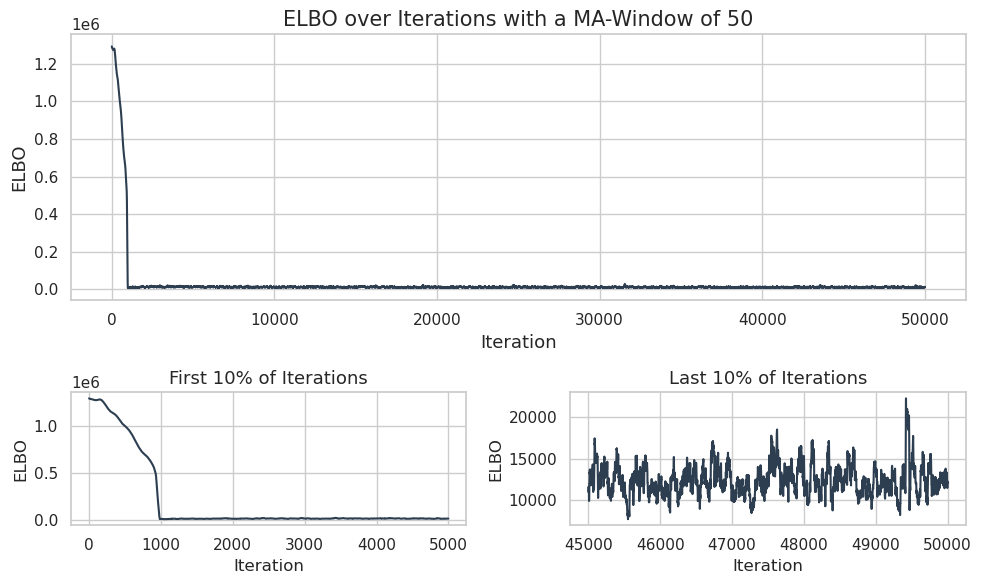

In [20]:
results_GPD_SYN_PSpline_FC = Y_GPD_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=50000,
    mb_size=None,
    lr=0.001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(1),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.1,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gpd_fits_dir + "/results_GPD_SYN_SLP.pkl", "wb") as f:
    pkl.dump(results_GPD_SYN_PSpline_FC, f)

plot_elbo(
    results_GPD_SYN_PSpline_FC["svi_metadata"]["num_iterations"], 
    results_GPD_SYN_PSpline_FC["losses"],
    loss_color,
    0.1,
    gpd_fits_dir,
    "linear_fit_loss_plot",
    window=50
)

/tmp/ipykernel_176841/320142752.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gpd_fits/regression_slp_plot.svg


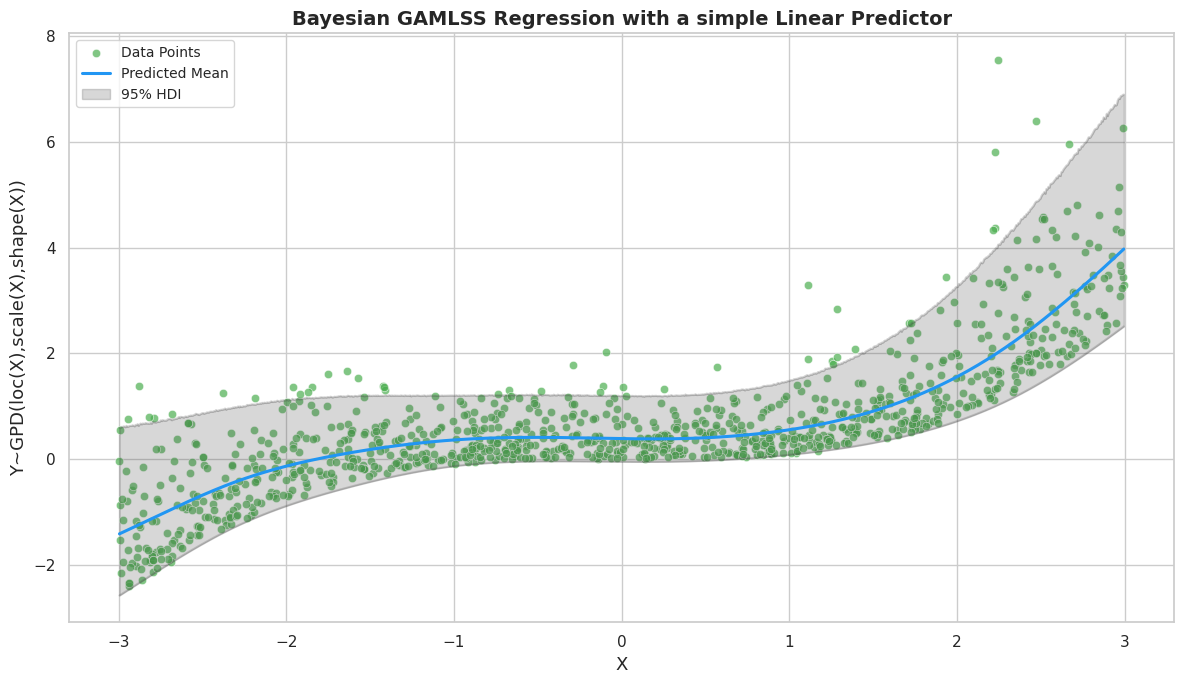

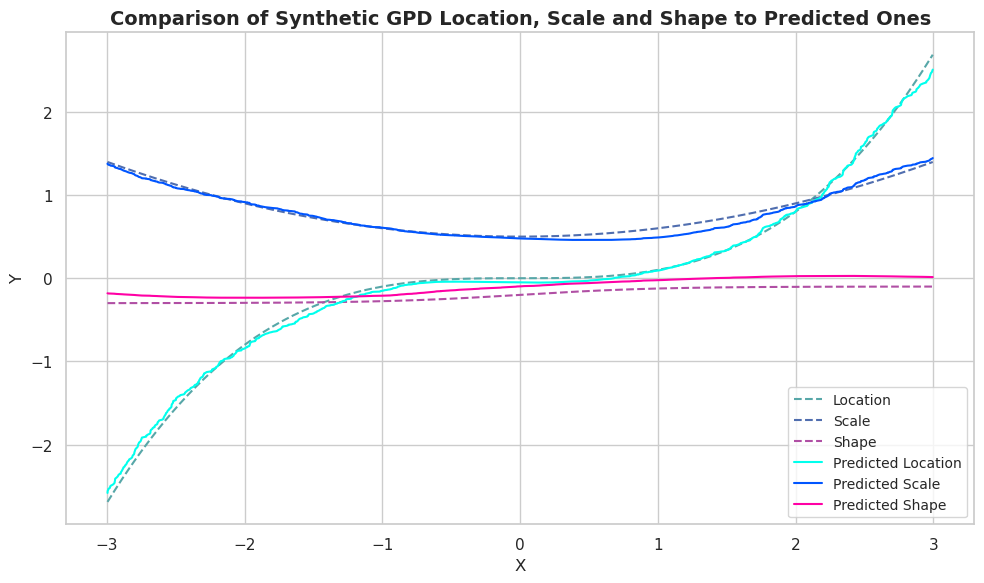

In [21]:
# Response is GPD GAMLSS Distributed Case
β0_loc = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_shape"]

X_min, X_max = X_GPD_SYN.min(), X_GPD_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape
GPD = tfd.GeneralizedPareto(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GPD.sample((100000,),PRNGKey(0))
mean_line = GPD.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_hdi(
    X_GPD_SYN,
    Y_GPD_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GPD(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with a simple Linear Predictor',
    save_path=gpd_fits_dir, 
    file_name="regression_slp_plot.svg"
)

plot_loc_scale_shape_comparison(
    X_GPD_SYN,
    line_loc=loc_fn,
    line_scale=scale_fn,
    line_shape=shape_fn,
    line_loc_pred=linear_predictor_loc,
    line_scale_pred=linear_predictor_scale,
    line_shape_pred=linear_predictor_shape,
    non_pred_palette=line_colors,
    pred_palette=pred_line_colors,
    title="Comparison of Synthetic GPD Location, Scale and Shape to Predicted Ones",
    xlabel="X",
    ylabel="Y",
)